In [107]:
from __future__ import print_function
import numpy as np
import astropy.units as u
import astropy.constants as consts
import matplotlib.pyplot as plt
import OpenGoddard.optimize as og
#from OpenGoddard.optimize import Problem, Guess, Condition, Dynamics
import math



In [108]:
consts.G

<<class 'astropy.constants.codata2014.CODATA2014'> name='Gravitational constant' value=6.67408e-11 uncertainty=3.1e-15 unit='m3 / (kg s2)' reference='CODATA 2014'>

In [109]:
consts.M_sun

<<class 'astropy.constants.iau2015.IAU2015'> name='Solar mass' value=1.9884754153381438e+30 uncertainty=9.236140093538353e+25 unit='kg' reference='IAU 2015 Resolution B 3 + CODATA 2014'>

In [110]:
u.G.si

Unit("0.0001 T")

In [111]:
u.year.si

Unit("3.15576e+07 s")

In [112]:
u.N.si

Unit("J / m")

In [113]:
class Orbiter:
    def __init__(self):
        
        #note, if d_ is used, it refers to dimensional quantity in SI units. 
        
        AU = 1*u.AU;
        mu_sun = consts.G*consts.M_sun #SI units
        year = u.year #seconds
        
        #set up non-d params
        
        self.lref = 1*AU; #1 AU
        self.vref = np.sqrt(mu_sun/self.lref) #v of earths orbit
        self.tref = self.lref/self.vref
        self.aref = (self.vref)**2/self.lref
        self.wref = 1/self.tref;
        
        self.d_mdry = 3500*u.kg; #kg
        
        #assign operating limits
        self.d_F_max = 0.5*u.N;
        
        self.d_a_max = self.d_F_max/self.d_mdry; #assuming 0.5N for vehicle mass of 5000 kg
        
        self.d_tf_max = 3.5*year;
        
        
        #assign initial conditions
        self.d_r0 = 1*AU;
        self.d_vr0 = 0*u.m/u.s;
        self.d_vt0 = np.sqrt(mu_sun/(1*AU));
        self.d_w0 =self.d_vt0/self.d_r0; #earths orbital speed
        
        
        
        self.d_rf = 0.723*AU;
        self.d_vrf = 0*u.m/u.s;
        self.d_final_apogee = 1.65*AU;
        self.d_final_semimajor = (self.d_rf+self.d_final_apogee)/2;        
        self.d_vtf = np.sqrt(mu_sun*(2/self.d_rf - 1/self.d_final_semimajor)); #vis viva equation at venus apogee.
        self.d_wf = self.d_vtf/self.d_rf;
        
        
        #non-dimensionalise
        self.u_max  = float((self.d_a_max/self.aref).si);
        self.r0     = float((self.d_r0 /self.lref).si);
        self.vr0    = float((self.d_vr0/self.vref).si);
        self.vt0    = float((self.d_vt0/self.vref).si);
        self.rf     = float((self.d_rf /self.lref).si);
        self.vrf    = float((self.d_vrf/self.vref).si);
        self.vtf    = float((self.d_vtf/self.vref).si);
        self.tf_max = float((self.d_tf_max/self.tref).si);


def dynamics(prob, obj, section):
    r   = prob.states(0, section)
    vr  = prob.states(1, section)
    vt  = prob.states(2, section)
    ur1 = prob.controls(0, section)
    ur2 = prob.controls(1, section)
    ut1 = prob.controls(2, section)
    ut2 = prob.controls(3, section)

    dx = og.Dynamics(prob, section)
    dx[0] = vr
    dx[1] = vt**2 / r - 1 / r**2 + (ur1 - ur2)
    dx[2] = - vr * vt / r + (ut1 - ut2)
    return dx()


def equality(prob, obj):
    r   = prob.states_all_section(0)
    vr  = prob.states_all_section(1)
    vt  = prob.states_all_section(2)
    ur1 = prob.controls_all_section(0)
    ur2 = prob.controls_all_section(1)
    ut1 = prob.controls_all_section(2)
    ut2 = prob.controls_all_section(3)
    tf  = prob.time_final(-1)

    result = og.Condition()

    # event condition
    result.equal(r[0], obj.r0)
    result.equal(vr[0], obj.vr0)
    result.equal(vt[0], obj.vt0)
    result.equal(r[-1], obj.rf)
    result.equal(vr[-1], obj.vrf)


    return result()


def inequality(prob, obj):
    r   = prob.states_all_section(0)
    vr  = prob.states_all_section(1)
    vt  = prob.states_all_section(2)
    ur1 = prob.controls_all_section(0)
    ur2 = prob.controls_all_section(1)
    ut1 = prob.controls_all_section(2)
    ut2 = prob.controls_all_section(3)
    tf  = prob.time_final(-1)

    result = og.Condition()

    # lower bounds
    result.lower_bound(r, 0.5*min(obj.r0,obj.rf))
    result.lower_bound(ur1, 0.0)
    result.lower_bound(ut1, 0.0)
    result.lower_bound(ur2, 0.0)
    result.lower_bound(ut2, 0.0)
    result.lower_bound(tf, 0.0)
    result.lower_bound(vt[-1],obj.vtf) #requries minimum final tangential speed, no upper bound set. 

    # upper bounds
    result.upper_bound(r, 3*max(obj.r0,obj.rf))
    result.upper_bound(np.sqrt(np.square(ur1-ur2) + np.square(ut1-ut2)), obj.u_max)
    #result.upper_bound(ut1, obj.u_max)
    #result.upper_bound(ur2, obj.u_max)
    #result.upper_bound(ut2, obj.u_max)
    result.upper_bound(tf, obj.tf_max)
    
    
    

    return result()


def cost(prob, obj):
    return 0.0


def running_cost(prob, obj):
    ur1 = prob.controls_all_section(0)
    ur2 = prob.controls_all_section(1)
    ut1 = prob.controls_all_section(2)
    ut2 = prob.controls_all_section(3)
    
    netaccel = np.sqrt(np.square(ur1 + ur2) + np.square(ut1 + ut2));
    
    if 0:
        print(type(ur1))
        print(ur1.size)
        print((ur1+ur2+ut1+ut2).size)
        print(netaccel.size)
    
    time_weight = 1/20

    return time_weight + netaccel

In [120]:
obj=Orbiter()

In [121]:
(prob.time_all_section)

array([ 0.        ,  0.21173002,  0.70442367,  1.46372544,  2.46990833,
        3.69690172,  5.11292394,  6.68129952,  8.36140779, 10.10973451,
       11.88099873, 13.62932545, 15.30943372, 16.8778093 , 18.29383152,
       19.52082492, 20.52700781, 21.28630957, 21.77900322, 21.99073324])

In [122]:
time_init = [0.0*u.s/u.s, obj.tf_max]

In [123]:
time_init

[<Quantity 0.>, 21.990733241731526]

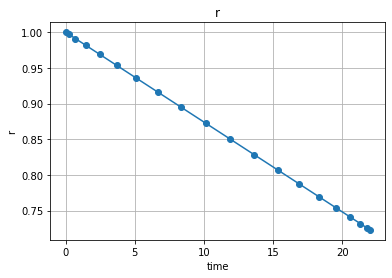

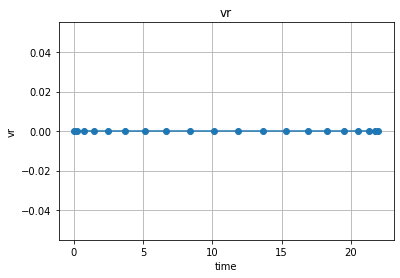

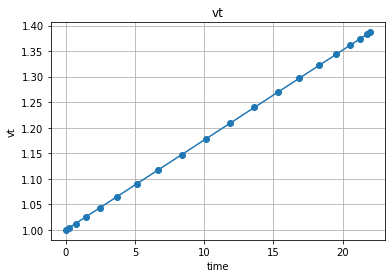

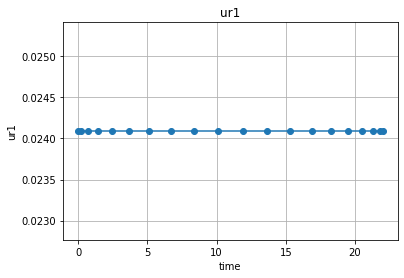

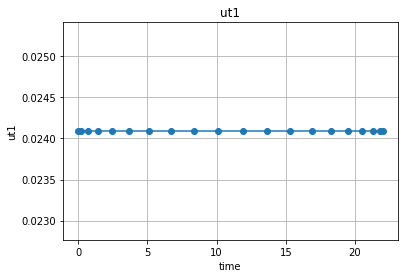

In [124]:
# ========================
plt.close("all")
plt.ion()
# Program Starting Point

obj = Orbiter()


time_init = [0.0, obj.tf_max]
n = [20]
num_states = [3]
num_controls = [4]
max_iteration = 5

flag_savefig = False

savefig_dir = "10_Low_Thrust_Orbit_Transfer/"

# ------------------------
# set OpenGoddard class for algorithm determination
prob = og.Problem(time_init, n, num_states, num_controls, max_iteration)


# ========================
# Initial parameter guess
r_init = og.Guess.linear(prob.time_all_section, obj.r0, obj.rf)
og.Guess.plot(prob.time_all_section, r_init, "r", "time", "r")


vr_init = og.Guess.linear(prob.time_all_section, obj.vr0, obj.vrf)
og.Guess.plot(prob.time_all_section, vr_init, "vr", "time", "vr")


vt_init = og.Guess.linear(prob.time_all_section, obj.vt0, obj.vtf)
og.Guess.plot(prob.time_all_section, vt_init, "vt", "time", "vt")


ur1_init = og.Guess.linear(prob.time_all_section, obj.u_max, obj.u_max)
og.Guess.plot(prob.time_all_section, ur1_init, "ur1", "time", "ur1")


ut1_init = og.Guess.linear(prob.time_all_section, obj.u_max, obj.u_max)
og.Guess.plot(prob.time_all_section, ut1_init, "ut1", "time", "ut1")


In [125]:
prob.set_states_all_section(0, r_init)
prob.set_states_all_section(1, vr_init)
prob.set_states_all_section(2, vt_init)
prob.set_controls_all_section(0, ur1_init)
prob.set_controls_all_section(2, ut1_init)

# ========================
# Main Process
# Assign problem to SQP solver
prob.dynamics = [dynamics]
prob.knot_states_smooth = []
prob.cost = cost
prob.running_cost = running_cost
prob.equality = equality
prob.inequality = inequality


def display_func():
    tf = prob.time_final(-1)
    print("tf: {0:.5f}".format(tf))


prob.solve(obj, display_func, ftol=1e-6)

---- iteration : 1 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.15383178992695512
            Iterations: 26
            Function evaluations: 3748
            Gradient evaluations: 26
Iteration limit exceeded
tf: 21.99073

---- iteration : 2 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.12318545032323391
            Iterations: 26
            Function evaluations: 3727
            Gradient evaluations: 26
Iteration limit exceeded
tf: 21.99073

---- iteration : 3 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.12230684840696186
            Iterations: 26
            Function evaluations: 3725
            Gradient evaluations: 26
Iteration limit exceeded
tf: 21.99073

---- iteration : 4 ----
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.12230531798235168
            Iterations: 14
            Function evaluations: 2017
       

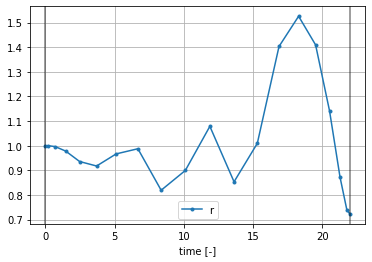

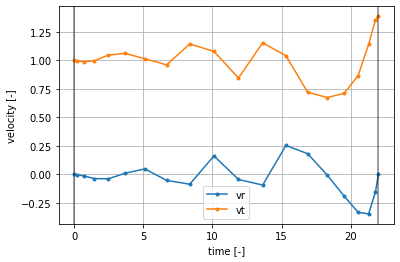

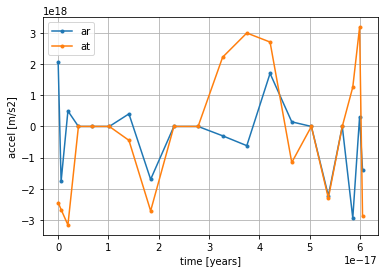

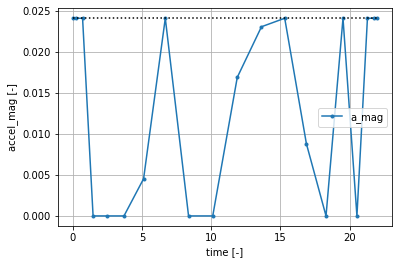

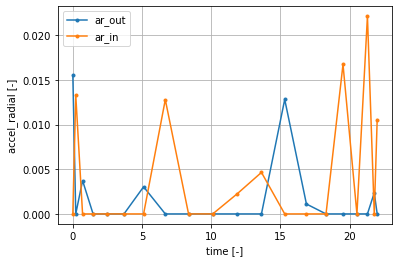

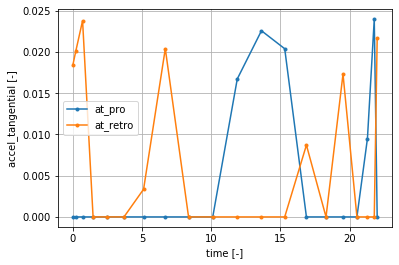

In [133]:
# ========================
# Post Process
# ------------------------
# Convert parameter vector to variable
r = prob.states_all_section(0)*obj.lref
vr = prob.states_all_section(1)
vt = prob.states_all_section(2)
ur1 = prob.controls_all_section(0)
ur2 = prob.controls_all_section(1)
ut1 = prob.controls_all_section(2)
ut2 = prob.controls_all_section(3)
time = prob.time_update()

year = 3.154*10**7 #seconds

accel_mag=np.sqrt(np.square(ur1-ur2)+np.square(ut1-ut2))



# ------------------------
# Visualizetion
plt.figure()
plt.plot(time, r, marker=".", label="r")
for line in prob.time_knots():
    plt.axvline(line, color="k", alpha=0.5)
plt.grid()
plt.xlabel("time [-]")
plt.ylabel("r [-]")
plt.legend(loc="best")
if(flag_savefig): plt.savefig(savefig_dir + "r" + ".png")

plt.figure()
plt.plot(time, vr, marker=".", label="vr")
plt.plot(time, vt, marker=".", label="vt")
for line in prob.time_knots():
    plt.axvline(line, color="k", alpha=0.5)
plt.grid()
plt.xlabel("time [-]")
plt.ylabel("velocity [-]")
plt.legend(loc="best")
if(flag_savefig): plt.savefig(savefig_dir + "velocity" + ".png")

plt.figure()
plt.plot(time*obj.tref/year, (ur1 - ur2)*obj.aref, marker=".", label="ar")
plt.plot(time*obj.tref/year, (ut1 - ut2)*obj.aref, marker=".", label="at")
plt.grid()
plt.xlabel("time [years]")
plt.ylabel("accel [m/s2]")
# plt.ylim([-0.02, 0.6])
plt.legend(loc="best")

plt.figure()
plt.plot(time, accel_mag, marker=".", label="a_mag")
plt.plot([0,time[-1]],[obj.u_max,obj.u_max],'k:')
plt.grid()
plt.xlabel("time [-]")
plt.ylabel("accel_mag [-]")
plt.legend(loc="best")

plt.figure()
plt.plot(time, ur1, marker=".", label="ar_out")
plt.plot(time, ur2, marker=".", label="ar_in")
plt.grid()
plt.xlabel("time [-]")
plt.ylabel("accel_radial [-]")
# plt.ylim([-0.02, 0.6])
plt.legend(loc="best")

plt.figure()
plt.plot(time, ut1, marker=".", label="at_pro")
plt.plot(time, ut2, marker=".", label="at_retro")
plt.grid()
plt.xlabel("time [-]")
plt.ylabel("accel_tangential [-]")
# plt.ylim([-0.02, 0.6])
plt.legend(loc="best")

if(flag_savefig): plt.savefig(savefig_dir + "thrust" + ".png")

In [132]:
r

<Quantity [1.        , 0.99994007, 0.99631763, 0.97817972, 0.93575312,
           0.91750658, 0.96669633, 0.98759235, 0.81912978, 0.89944787,
           1.07856042, 0.85336572, 1.00945789, 1.40286891, 1.52554705,
           1.40923595, 1.14182917, 0.87226567, 0.73939733, 0.723     ] AU>